In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 1 # Grayscale images have one channel
EPOCHS = 50

In [4]:
Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Training Images",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1646 files belonging to 4 classes.


In [5]:
class_names = Dataset.class_names
class_names

['Fetal abdomen', 'Fetal brain', 'Fetal femur', 'Fetal thorax']

In [6]:
len(Dataset)

52

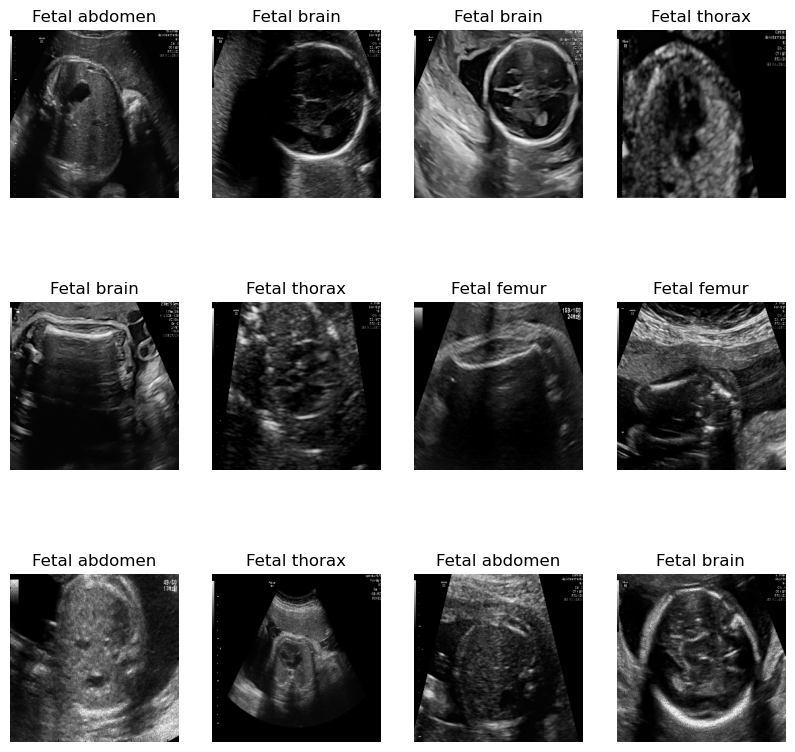

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in Dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [9]:
len(Dataset)

52

In [10]:
# 90% training images => model training
# 10% remaining images => validation
# External Test images => testing

In [12]:
train_size = 0.9
len(Dataset)*train_size

46.800000000000004

In [11]:
val_size = 0.1
len(Dataset)*val_size

5.2

In [13]:
train_ds = Dataset.take(46)
len(train_ds)

46

In [15]:
val_ds = Dataset.skip(46)
len(val_ds)

6

In [29]:
import math

In [33]:
def get_dataset_partition_tf(ds, train_split=0.9, val_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = math.ceil(int(train_split * ds_size))
    val_size = math.ceil(int(val_split * ds_size))
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds,val_ds

In [34]:
train_ds,val_ds = get_dataset_partition_tf(Dataset)

In [35]:
print(len(train_ds))
print(len(val_ds))

46
5


In [36]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "External Test images-20230824T140412Z-001",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 40 files belonging to 1 classes.


In [37]:
print(len(test_ds))

2


In [38]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [39]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [40]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [79]:
num_channels = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, num_channels)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [80]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, None)    0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, None)    0         
                                                                 
 conv2d_48 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_48 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_49 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                

In [81]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [50]:
# IMAGE_SIZE = 256
# BATCH_SIZE = 32
# CHANNELS = 1
# EPOCHS = 50

In [82]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/50


46/46 [==============================] - 48s 989ms/step - loss: 1.3431 - accuracy: 0.3232 - val_loss: 1.2358 - val_accuracy: 0.3313
Epoch 2/50
46/46 [==============================] - 45s 985ms/step - loss: 1.0892 - accuracy: 0.5172 - val_loss: 0.7815 - val_accuracy: 0.7625
Epoch 3/50
46/46 [==============================] - 42s 911ms/step - loss: 0.8640 - accuracy: 0.6768 - val_loss: 0.7540 - val_accuracy: 0.7437
Epoch 4/50
46/46 [==============================] - 44s 955ms/step - loss: 0.6890 - accuracy: 0.7442 - val_loss: 0.5214 - val_accuracy: 0.8250
Epoch 5/50
46/46 [==============================] - 40s 879ms/step - loss: 0.7000 - accuracy: 0.7462 - val_loss: 0.5430 - val_accuracy: 0.8250
Epoch 6/50
46/46 [==============================] - 42s 913ms/step - loss: 0.6286 - accuracy: 0.7799 - val_loss: 0.5479 - val_accuracy: 0.7750
Epoch 7/50
46/46 [==============================] - 41s 885ms/step - loss: 0.5763 - accuracy: 0.7944 - val_loss: 0.4215 - val_accuracy: 0.8562
Epoch 8/50

In [72]:
# Print input shape of the model
print("Model Input Shape:", model.input_shape)

# Print shape of a batch from train_ds
for images, labels in train_ds.take(1):
    print("Batch Input Shape:", images.shape)

Model Input Shape: (None, 256, 256, None)
Batch Input Shape: (32, 256, 256, 3)


In [73]:
# Print a batch from train_ds
for images, labels in train_ds.take(1):
    print("Batch Input Shape:", images.shape)
    print("Batch Label Shape:", labels.shape)

Batch Input Shape: (32, 256, 256, 3)
Batch Label Shape: (32,)


In [74]:
for images, labels in train_ds.take(1):
    preprocessed_images = resize_and_rescale(images)
    print("Batch Preprocessed Images Shape:", preprocessed_images.shape)

Batch Preprocessed Images Shape: (32, 256, 256, 3)


In [75]:
for layer in model.layers:
    print("Layer:", layer.name)
    print("Output Shape:", layer.output_shape)


Layer: sequential_3
Output Shape: (None, 256, 256, None)
Layer: sequential_4
Output Shape: (None, 256, 256, None)
Layer: conv2d_36
Output Shape: (None, 254, 254, 32)
Layer: max_pooling2d_36
Output Shape: (None, 127, 127, 32)
Layer: conv2d_37
Output Shape: (None, 125, 125, 64)
Layer: max_pooling2d_37
Output Shape: (None, 62, 62, 64)
Layer: conv2d_38
Output Shape: (None, 60, 60, 64)
Layer: max_pooling2d_38
Output Shape: (None, 30, 30, 64)
Layer: conv2d_39
Output Shape: (None, 28, 28, 64)
Layer: max_pooling2d_39
Output Shape: (None, 14, 14, 64)
Layer: conv2d_40
Output Shape: (None, 12, 12, 64)
Layer: max_pooling2d_40
Output Shape: (None, 6, 6, 64)
Layer: conv2d_41
Output Shape: (None, 4, 4, 64)
Layer: max_pooling2d_41
Output Shape: (None, 2, 2, 64)
Layer: flatten_6
Output Shape: (None, 256)
Layer: dense_12
Output Shape: (None, 64)
Layer: dense_13
Output Shape: (None, 4)
